In [29]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (24, 8)
import numpy as np
import pandas as pd
import json
import os
from sklearn import linear_model
from elasticsearch import Elasticsearch

In [30]:
client = Elasticsearch()
query_total_bucket = {
  "aggs": {
    "my_aggregation": {
      "date_histogram": {
        "field":     "@timestamp",
        "interval":  "1H"
      }
    }
  }
}

response = client.search(
    index="movi*",
    size=0,
    body=query_total_bucket)

print("Query time: ", response['took'])

#nota: hay que buscar la mejor manera de hacer esto porque parece rebuscado
dates = []
count = []
for element in response['aggregations']['my_aggregation']['buckets']:
    dates.append(pd.to_datetime(element['key_as_string']))
    count.append(element['doc_count'])
    
main_resampled = pd.Series(count, index=dates)

Query time:  140


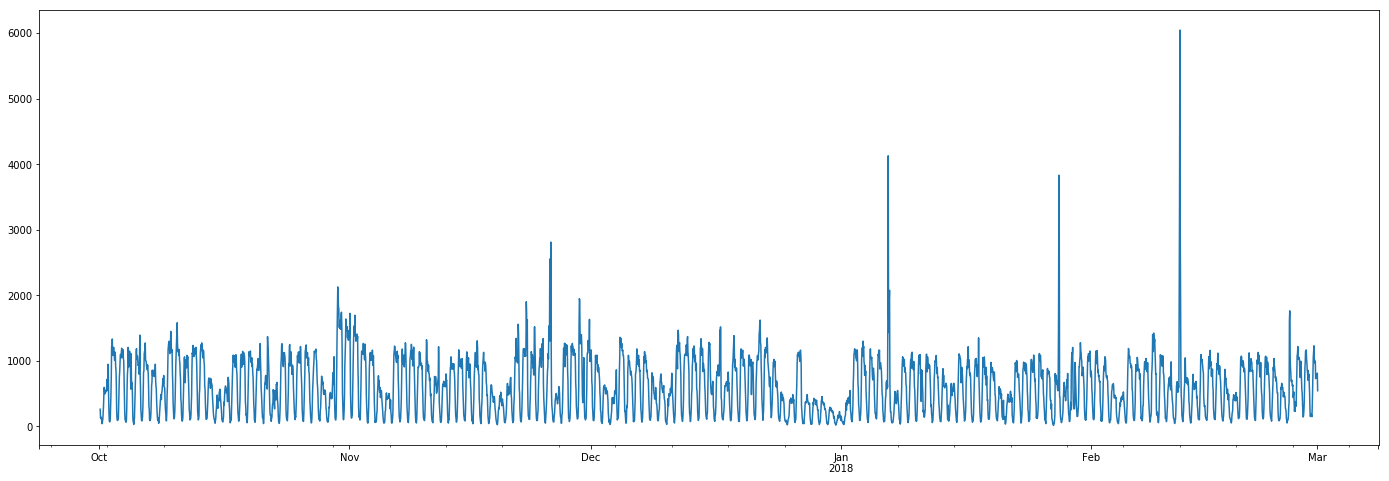

In [31]:
main_resampled.plot()

In [32]:
training = main_resampled
test = main_resampled

In [33]:
def groupBy(data, window_size):
    result = []
    for i in range(window_size, len(data)):
        result.append(data[i-window_size:i])
    return result

In [34]:
PAST = 48
train_Y = training.values[PAST:]
train_X = groupBy(training.values, PAST)

In [35]:
clf = linear_model.Lasso()
clf.fit(train_X, train_Y)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [36]:
grouped_test = groupBy(test, PAST)
index = test.index[PAST:]
predicted_vals = clf.predict(grouped_test)
# Put back starting values over which we can't predict
predicted = test[:PAST].append( pd.Series(predicted_vals, index = index) )

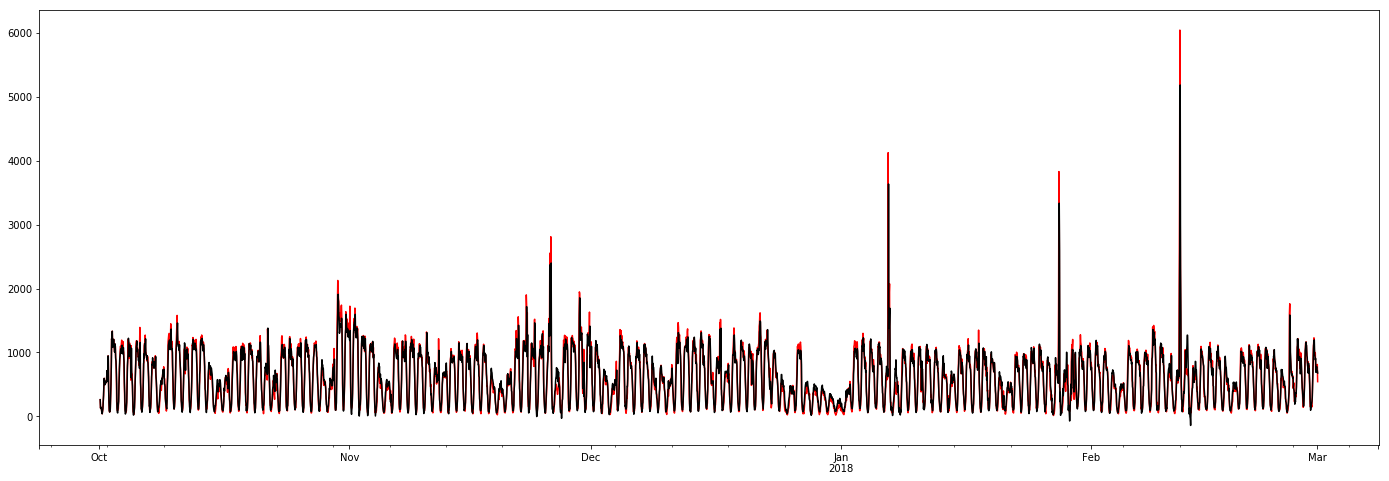

In [37]:
test.plot(color='red')
predicted.plot(color='black')

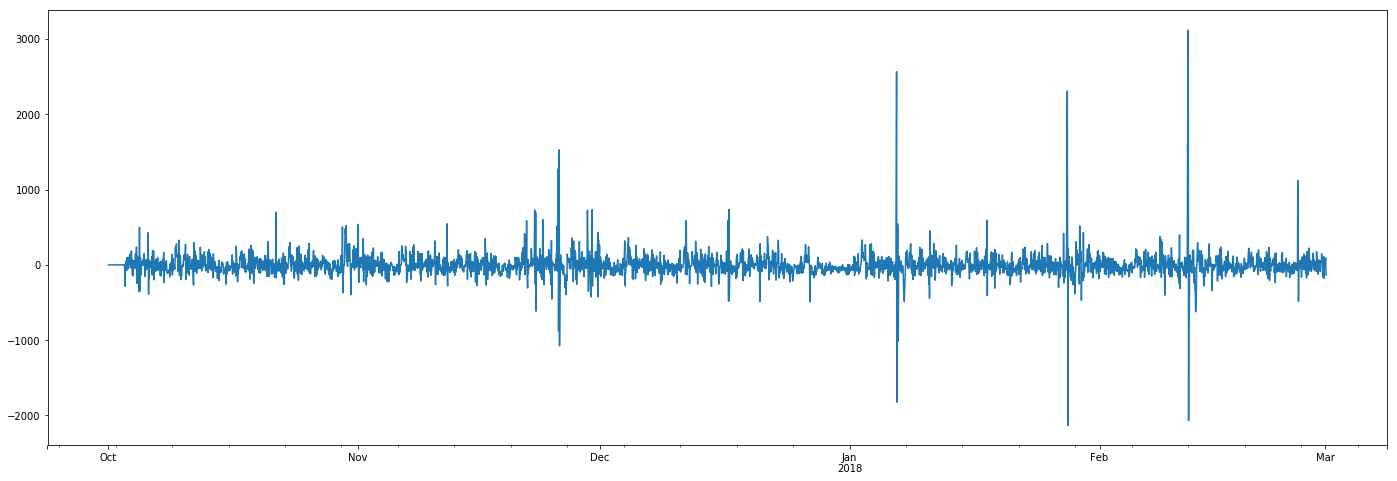

In [38]:
# Calculate difference between original and reconstructed
diff = test - predicted
diff.plot()

In [39]:
from functools import partial
def remove_non_anomalies(val, lim):
    return -100.0 if abs(val) > lim else 0.0

In [40]:
# Trim para mejor visualizacion
test_trimmed = test.apply(lambda x: x if x < 1000 else 1000)

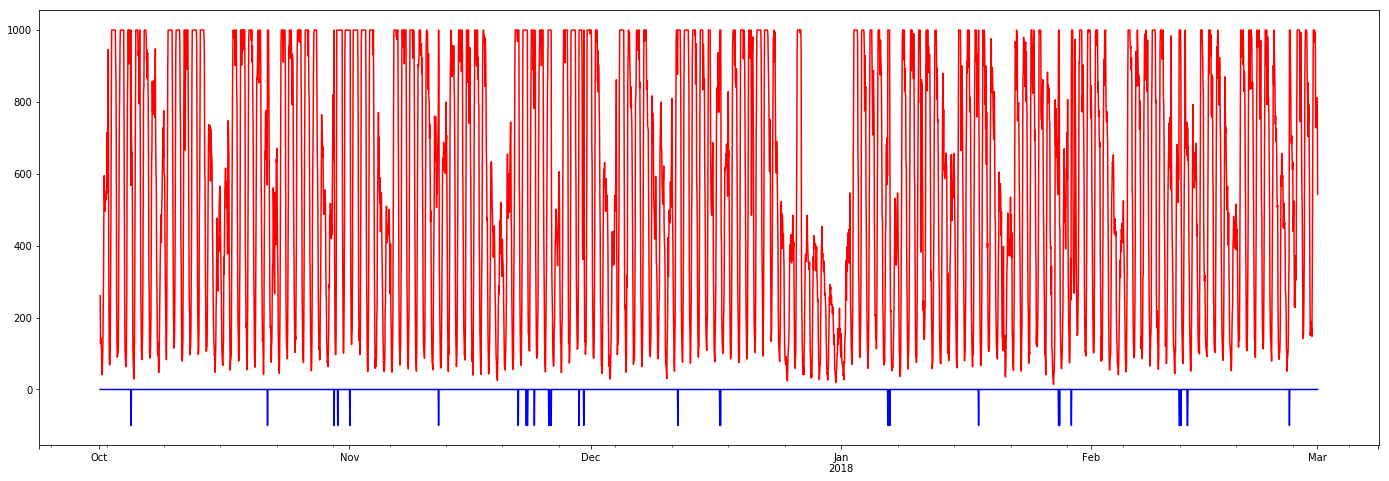

In [41]:
# Highlight anomalies in blue with 3sigma deviation after reconstruction
max_std = diff.std()*3
diff.apply(partial(remove_non_anomalies, lim=max_std)).plot(color='blue')
test_trimmed.plot(color='red')

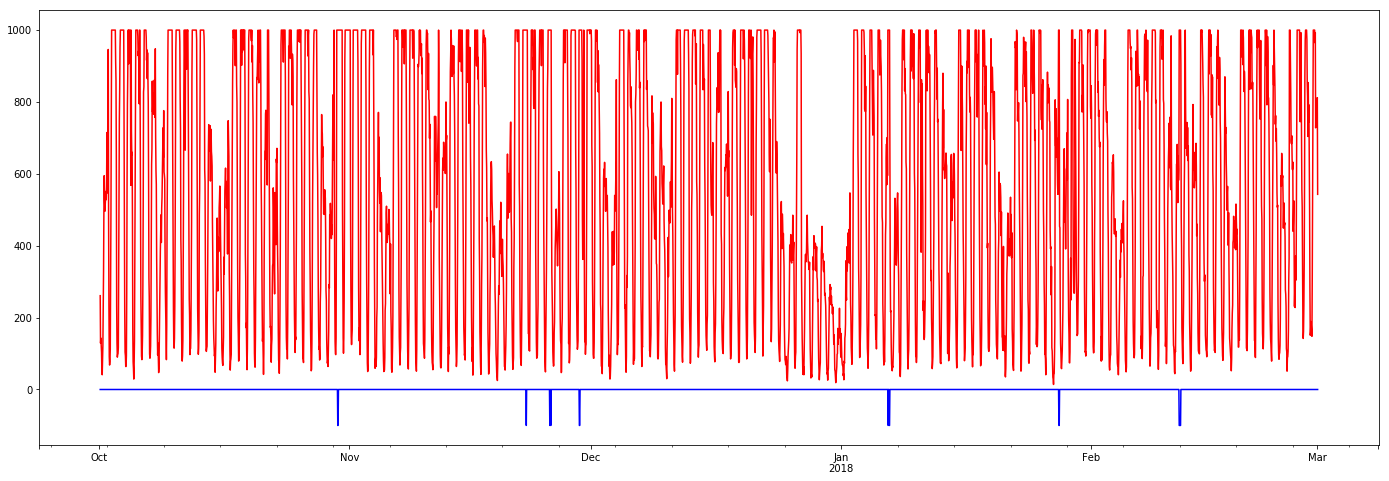

In [42]:
# For comparison, highlight anomalies using regular 3sigma
(training-training.mean()).apply(partial(remove_non_anomalies, lim=training.std()*3)).plot(color='blue')
test_trimmed.plot(color='red')